In [ ]:
# Based on 0230710,0230711.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve,generate_binary_structure
from scipy.signal import correlate
from numba import njit
import pickle
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
# basic functions
@njit
def init_lattice(L,ratio):
  r=max(ratio,1-ratio)
  l=np.random.random((L,L))
  l=l*(l>=r)
  l=1-l
  l=l*(l>=r)
  if ratio<=0.5:
    l=1-l
  l=2*l-1
  return l

def get_energy(l):
  # filter
  ker=np.array([[0,1,0],[1,0,1],[0,1,0]])

  # neighborhood magnetic field
  h=convolve(l,ker, mode='wrap')

  # energy
  E=-h*l
  return E


In [ ]:
# metropolis functions
djs=np.array([[1,0],[0,1],[-1,0],[0,-1]])
def metro_flip(l,b):

  L=l.shape[0]
  for i in range(L**2): # 1
    j=np.random.randint(0,L,2)
    dE=-2*get_energy(l)[j[0],j[1]]
    p=min(1,np.exp(-b*dE))
    l[j[0],j[1]]*=(-1)**(np.random.random()<=p)

  return l

def metropolis(l,iter,cut):
  L=l.shape[0]
  u_t=np.zeros((iter-cut))
  b=np.log(1+np.sqrt(2))/2 # critical temperature
  for i in range(iter):

    '''if i%1==0:
      plt.imshow(l,cmap='Greys')
      plt.title(f't={i}')
      plt.colorbar()
      plt.show()'''
    l=metro_flip(l,b)
    if i>=cut:
      u_t[i-cut-1]=get_energy(l).sum()/L**2
  return u_t

def loop_over_lattice_size(Ls,iter):
  cut=int(iter/2)#1000
  u_t_L=np.zeros((len(Ls),iter-cut))
  for i,L in enumerate(Ls):
    ratio=1
    l=init_lattice(L,ratio)
    u_t=metropolis(l,iter,cut)
    u_t_L[i]=u_t
    print('Completed: ',Ls[i])
  return u_t_L


In [ ]:
# switch to some wolff functions

djs=np.array([[1,0],[0,1],[-1,0],[0,-1]])
def flip(l,b):
  p=1-np.exp(-2*b)
  L=l.shape[0]
  j=np.random.randint(0,L,2)
  surface_of_growth=[j]
  while len(surface_of_growth)!=0:
    #print(surface_of_growth)
    j=surface_of_growth[0]
    for i in (j+djs)%L:

      if l[i[0],i[1]]==l[j[0],j[1]]:
        dice=np.random.random()
        if dice<=p:
          n=0
          for k in surface_of_growth:
            n+=(i==k).prod()
          if n==0:
            surface_of_growth.append(i)

    l[j[0],j[1]]*=-1
    surface_of_growth.pop(0)
  return l

def wolff(l,iter,cut):
  L=l.shape[0]
  u_t=np.zeros((iter-cut))
  b=np.log(1+np.sqrt(2))/2 # critical temperature
  for i in range(iter):

    '''if i%1==0:
      plt.imshow(l,cmap='Greys')
      plt.title(f't={i}')
      plt.show()'''
    l=flip(l,b)
    if i>=cut:
      u_t[i-cut-1]=get_energy(l).sum()/L**2
  return u_t

def loop_over_lattice_size(Ls,iter):
  cut=int(iter/2)#1000
  u_t_L=np.zeros((len(Ls),iter-cut))
  for i,L in enumerate(Ls):
    ratio=1
    l=init_lattice(L,ratio)
    u_t=wolff(l,iter,cut)
    u_t_L[i]=u_t
    print('Completed: ',Ls[i])
  return u_t_L

In [ ]:

def fit(cut,cut_):
  # cut_ from 15 to 100, since now tail is suppressed by zero-padding
  # no restriction to 1 for coef, no abs for taus

  taus=np.zeros((len(Ls)))
  fig,ax=plt.subplots()
  for i,autos in enumerate(autos_L):
    markers,caps,bars=ax.errorbar(range(cut),autos.mean(0)[:cut],yerr=autos.std(0)[:cut]/np.sqrt(autos.shape[0]) ,capsize=2,label=f'L={Ls[i]}',alpha=0.7)
    [bar.set_color('pink') for bar in bars]
    [bar.set_alpha(0.3) for bar in bars]

    # fit sum_i a_i e**(-t/tau_i) to auto

    popt, pcov = curve_fit(lambda t,tau0,tau1,tau2,a0,a1,a2 : abs(a0)*np.exp(-t/tau0)+abs(a1)*np.exp(-t/tau1)+abs(a2)*np.exp(-t/tau2), np.arange(cut_), autos.mean(0)[:cut_])
    tau0,tau1,tau2,a0,a1,a2=popt
    #tau0,tau1,tau2=abs(tau0),abs(tau1),abs(tau2)
    a0,a1,a2=abs(a0),abs(a1),abs(a2)
    taus_=np.array([tau0,tau1,tau2])
    aS=np.array([a0,a1,a2])
    print(taus_,aS)
    taus[i]=taus_.max()

    # plot fitted line
    t=np.linspace(0,cut,cut+1)
    fit=a0*np.exp(-t/tau0)+a1*np.exp(-t/tau1)+a2*np.exp(-t/tau2)
    ax.plot(fit,alpha=1)

    '''fits=[0,0,0]
    fits[0]=a0*np.exp(-t/tau0)
    fits[1]=a1*np.exp(-t/tau1)
    fits[2]=a2*np.exp(-t/tau2)[:3]
    for j in range(3):
      ax.plot(fits[j],label=f'a={aS[j]}')'''
  print(taus)
  ax.legend()
  plt.yscale('log')
  plt.show()


  # fit AL**z to tau(L)
  popt, pcov = curve_fit(lambda L,A,z :A*L**z, Ls, taus)
  A,z=popt

  plt.scatter(Ls,taus)
  Lss=np.linspace(1,50,50)
  plt.plot(Lss,A*Lss**z,label=f'slope={z}')
  #plt.plot(Lss,A*Lss**0.35)
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()

  return taus



In [ ]:
# changing to zero-padding from real-data-padding to try to suppress the noise (insignificant)
def bootstrap_auto(u_t_L,blocksize,no_of_bootstraps):
  autos_L=np.zeros((len(Ls),no_of_bootstraps,blocksize))
  for k,u_t in enumerate(u_t_L):
    for i in range(no_of_bootstraps):

      j=np.random.randint(0,len(u_t)-2*blocksize+1)
      block=u_t[j:j+blocksize]
      #auto=correlate(u_t[j:]-u_t[j:].mean(),block-block.mean(),mode='valid')
      #auto=auto[:blocksize]
      auto=correlate(block-block.mean(),block-block.mean(),mode='full')
      auto=auto[blocksize-1:]
      autos_L[k][i]=auto/auto[0]
      '''plt.plot(auto/auto[0])
    plt.show()'''
  return autos_L

#### Run

In [ ]:
%%time
u_t_L = loop_over_lattice_size([8,10,12],200000) # the map from t to u as a function of L, metropolis

Completed:  8
Completed:  10
Completed:  12
CPU times: user 1h 10min 59s, sys: 14.9 s, total: 1h 11min 14s
Wall time: 1h 12min 10s


In [ ]:
with open('drive/My Drive/0230713_u_t_L(8_10_12)(met)(iter=200000).pickle','wb') as f:
  pickle.dump(u_t_L,f)

In [ ]:
%%time
u_t_L = loop_over_lattice_size([23,27,32],200000) # wolff

In [ ]:
with open('drive/My Drive/0230713_u_t_L(23_27_32)(wol)(iter=200000).pickle','wb') as f:
  pickle.dump(u_t_L,f)

#### Analysis

In [ ]:
with open('drive/My Drive/0230713_u_t_L(8_10_12)(met)(iter=200000).pickle','rb') as f:
  u_t_L_met=pickle.load(f)
with open('drive/My Drive/0230713_u_t_L(23_27_32)(wol)(iter=200000).pickle','rb') as f:
  u_t_L_wol=pickle.load(f)

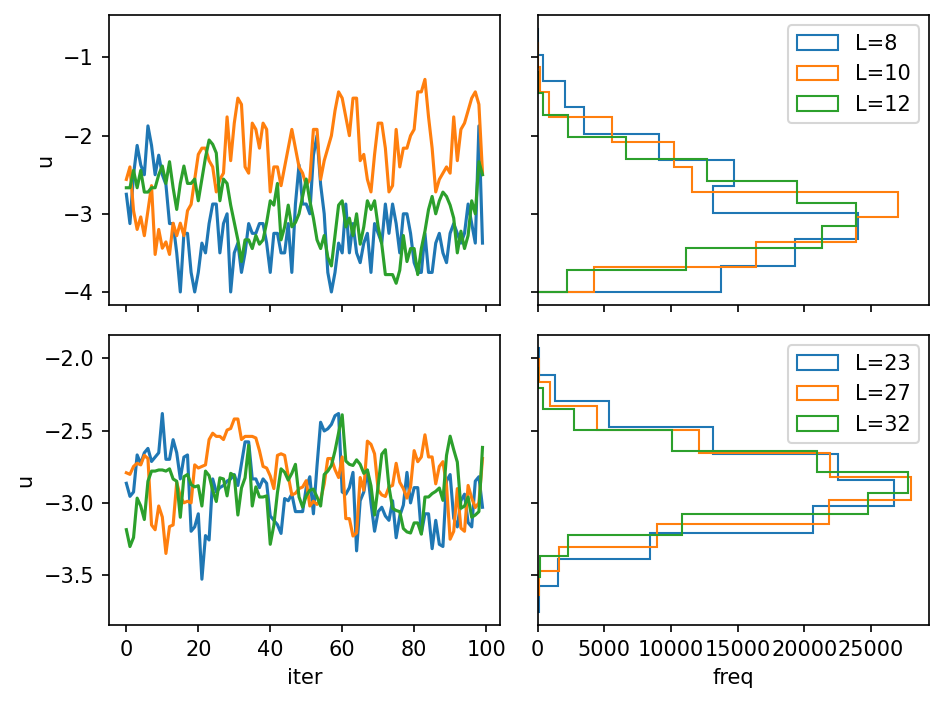

In [ ]:
fig,ax=plt.subplots(2,2,sharey='row',sharex='col')
Ls_met,Ls_wol=[8,10,12],[23,27,32]
[ax[0,0].plot(u_t[-100:]) for i,u_t in enumerate(u_t_L_met)]
[ax[0,1].hist(u_t,histtype='step',orientation='horizontal',label=f'L={Ls_met[i]}') for i,u_t in enumerate(u_t_L_met)]
[ax[1,0].plot(u_t[-100:]) for i,u_t in enumerate(u_t_L_wol)]
[ax[1,1].hist(u_t,histtype='step',orientation='horizontal',label=f'L={Ls_wol[i]}') for i,u_t in enumerate(u_t_L_wol)]
ax[0,0].set_ylabel('u')
ax[1,0].set_ylabel('u')
ax[1,0].set_xlabel('iter')
ax[1,1].set_xlabel('freq')
ax[0,1].legend()
ax[1,1].legend()
plt.tight_layout()
fig.set_dpi(150)

one can see that qualitatively, the fluctuations are happening at similar rate but are slightly faster for the lower graph. one sees that the smallest oscillation is happening at a period of about 10 monte carlo steps for met. we proceed to quantify this otherwise vague "speed of fluctuation"

##### hide

In [ ]:
with open('drive/My Drive/0230713_u_t_L(8_10_12)(met)(iter=200000).pickle','rb') as f:
  u_t_L=pickle.load(f)

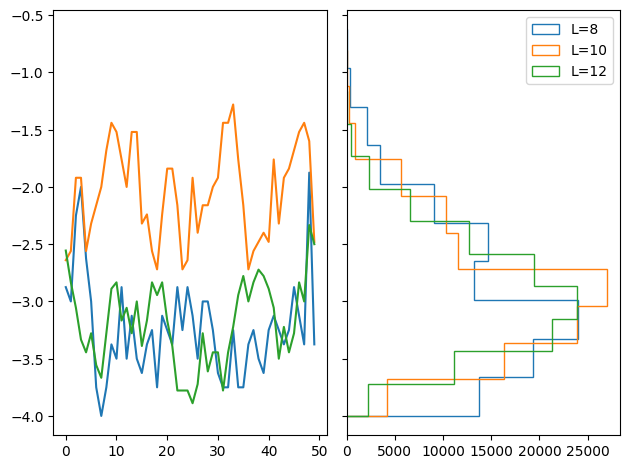

In [ ]:
Ls=[8,10,12]
fig,ax=plt.subplots(1,2,sharey='row')
[ax[0].plot(u_t[-50:]) for i,u_t in enumerate(u_t_L)]
[ax[1].hist(u_t,histtype='step',orientation='horizontal',label=f'L={Ls[i]}') for i,u_t in enumerate(u_t_L)]
plt.legend()
plt.tight_layout()

In [ ]:
with open('drive/My Drive/0230713_u_t_L(23_27_32)(wol)(iter=200000).pickle','rb') as f:
  u_t_L=pickle.load(f)

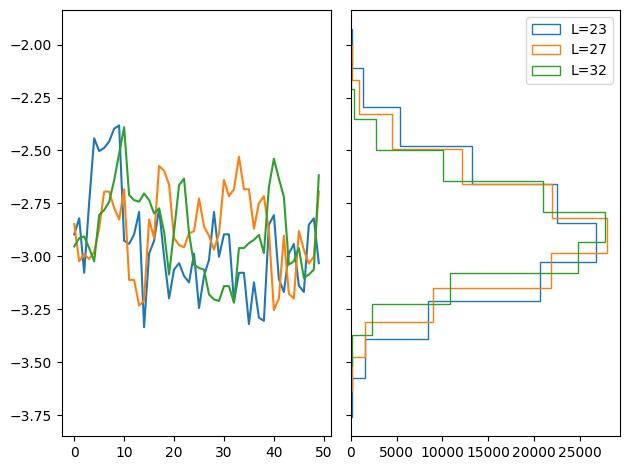

In [ ]:
Ls=[23,27,32]
fig,ax=plt.subplots(1,2,sharey='row')
[ax[0].plot(u_t[-50:],label=f'L={Ls[i]}') for i,u_t in enumerate(u_t_L)]
[ax[1].hist(u_t,histtype='step',orientation='horizontal',label=f'L={Ls[i]}') for i,u_t in enumerate(u_t_L)]
plt.legend()
plt.tight_layout()

##### unhide

In [ ]:
%%time
Ls=[8,10,12]   # context
blocksize=1000
no_of_bootstraps=10000
autos_L=bootstrap_auto(u_t_L,blocksize,no_of_bootstraps)

CPU times: user 10.6 s, sys: 186 ms, total: 10.8 s
Wall time: 10.9 s


<ipython-input-54-5aa5990ab8ad>:14: RuntimeWarning: overflow encountered in exp
  popt, pcov = curve_fit(lambda t,tau0,tau1,tau2,a0,a1,a2 : abs(a0)*np.exp(-t/tau0)+abs(a1)*np.exp(-t/tau1)+abs(a2)*np.exp(-t/tau2), np.arange(cut_), autos.mean(0)[:cut_])


[7.6771465  7.67850293 1.45350476] [0.37181426 0.33090394 0.29660302]
[ 7.84172715  1.29608373 10.18433159] [1.83806466e-08 2.83049918e-01 7.18276055e-01]
[17.3695737  17.37478901  2.24907224] [0.47225002 0.0898501  0.43277228]
[ 7.67850293 10.18433159 17.37478901]


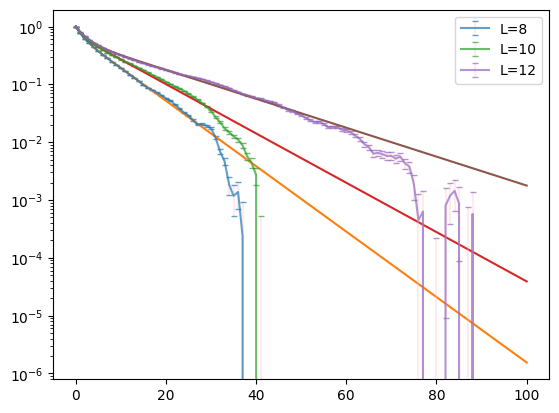

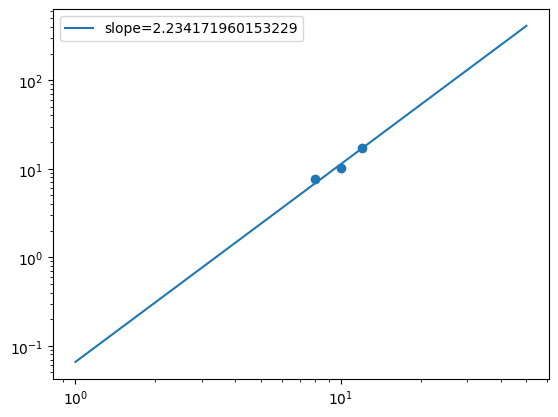

In [ ]:
cut=100 # for display
cut_=700 # for fit
taus_met=fit(cut,cut_)

In [ ]:
%%time
Ls=[23,27,32]   # context
blocksize=1000
no_of_bootstraps=10000
autos_L=bootstrap_auto(u_t_L,blocksize,no_of_bootstraps)


CPU times: user 9.11 s, sys: 193 ms, total: 9.31 s
Wall time: 9.35 s


[0.92962    0.92961991 3.42740251] [0.0577098  0.0577095  0.88485009]
[3.83741833 0.98959664 0.98967457] [0.890644   0.04898836 0.06074053]
[3.88334165 3.88341814 0.62474239] [0.18097818 0.75931052 0.05990427]
[3.42740251 3.83741833 3.88341814]


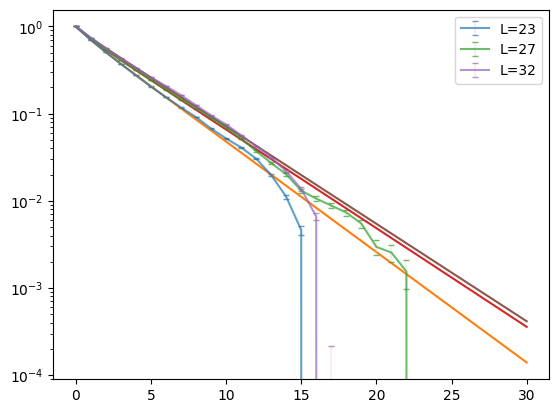

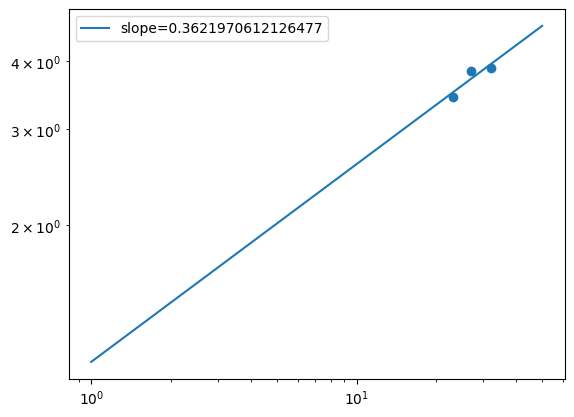

In [ ]:
cut=30 # for display
cut_=100 # for fit
taus_wolff=fit(cut,cut_)

Text(0.5, 0, 'L')

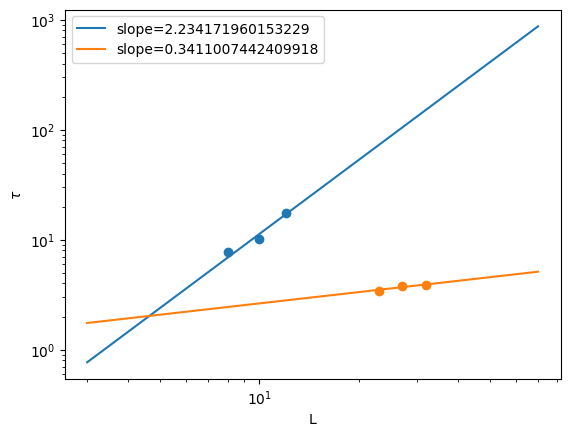

In [ ]:
# fit AL**z to tau(L)
Ls=[8,10,12]
popt, pcov = curve_fit(lambda L,A,z :A*L**z, Ls, taus_met)
A,z=popt
plt.scatter(Ls,taus_met)
Lss=np.linspace(3,70,50)
plt.plot(Lss,A*Lss**z,label=f'slope={z}')


Ls=[23,27,32]
popt, pcov = curve_fit(lambda L,A,z :A*L**z, Ls, taus_wolff)
A,z=popt
plt.scatter(Ls,taus_wolff)
plt.plot(Lss,A*Lss**z,label=f'slope={z}')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.ylabel(r'$\tau$')
plt.xlabel('L')